In [1]:
%matplotlib widget
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:

from occupancy.datasets.nuscenes import NuscenesDataset
from nuscenes.nuscenes import NuScenes
nusc = NuscenesDataset(
    version='v1.0-trainval',
    data_dir='/mnt/f/datasets/nuscenes/',
    verbose=True)


In [3]:
data = nusc[120]

In [4]:
pcd = data.lidar_top.location[:, :3]
pcd.shape

torch.Size([1, 3, 34720])

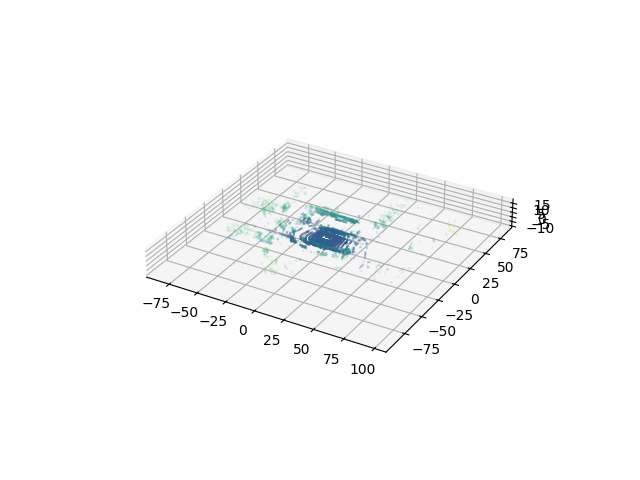

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcd[:, 0], pcd[:, 1], pcd[:, 2], s=0.01, marker='.',c=pcd[:, 2], alpha=0.85, cmap='viridis')
ax.set_box_aspect((1, 1, 0.125))

In [37]:
import torch

z = -1
r = 1
z = torch.tensor(z)
r = torch.tensor(r)
torch.asin(r / z)

tensor(-1.5708)

tensor([[-6971069,  -451494,  -271100,  ...,   402258,   320688,   937502],
        [ -649551,   -61809,   -43079,  ...,   -44825,   -51142,  -174404],
        [       1,        1,        1,  ...,        1,        1,        1]])
5580
tensor([219, 219, 220,  ..., 897, 898, 899]) tensor([1581, 1593, 1571,  ..., 1131, 1142, 1153])


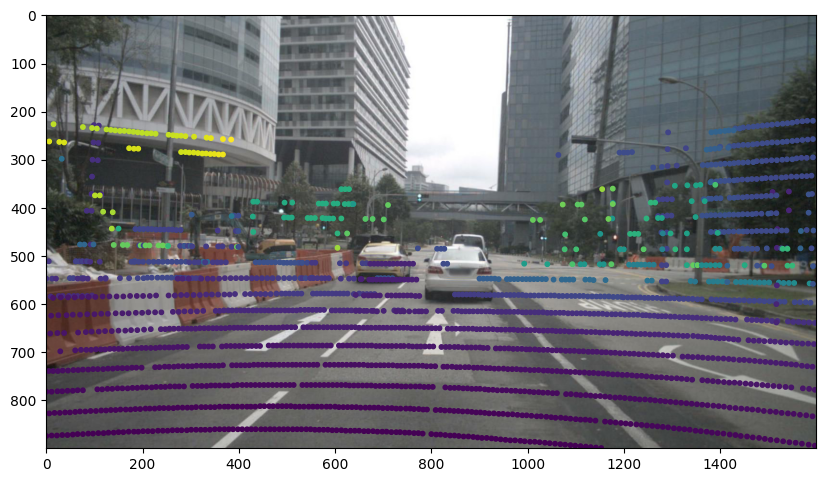

In [ ]:
fig = data.view_pointcloud_on_image(data.cam_front, data.lidar_top)
fig

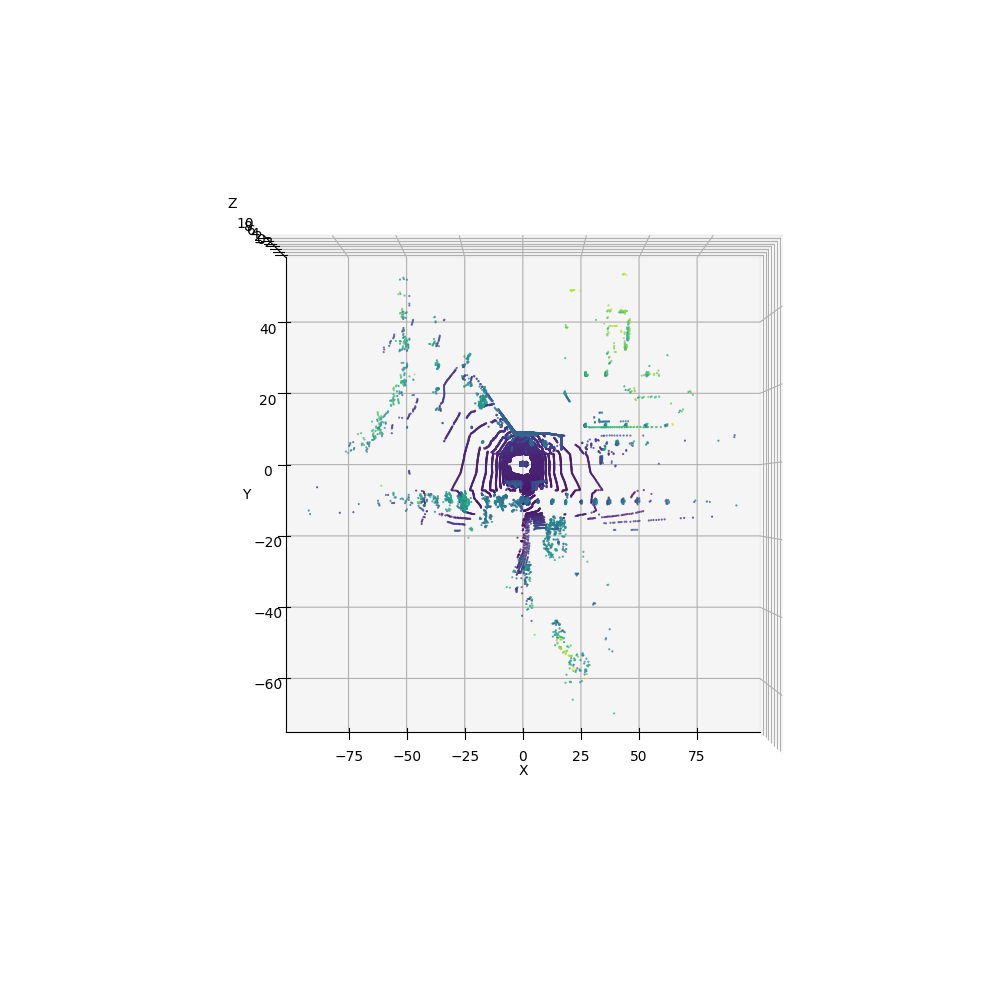

In [ ]:
from torch import Tensor
from occupancy.datasets.nuscenes import NuScenesImage, NuScenesPointCloud
import roma
from scipy.spatial.transform import Rotation as R

data = nusc[10]
#data.lidar_top.towards(data.cam_front)
voxel = data.lidar_top.voxel[0, 0]
#x, y, z = torch.where(voxel)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = data.lidar_top.location[:, 0]
y = data.lidar_top.location[:, 1]
z = data.lidar_top.location[:, 2]
ax.scatter(x, y, z, s=1, marker='.',c=z, alpha=0.85, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(azim=-90, elev=90)

In [ ]:
def equi_to_polar(u, v):
    """
    u: (N, H, W)
    v: (N, H, W)

    Returns:
        theta: (N, H, W)
        phi: (N, H, W)
    """
    theta = torch.atan2(u, v)
    phi = torch.sqrt(u ** 2 + v ** 2)
    return theta, phi

def concat_panoramic(multi_views, intrinsic, rotation, translation, out_size: int = 1024):
    """
    multi_views: (N, 3, H, W)
    intrinsic: (N, 3, 3)
    rotation: (N, 3, 3)
    translation: (N, 3)
    """

    u, v = torch.meshgrid(torch.linspace(-1, 1, out_size), torch.linspace(-1, 1, out_size * 2), indexing='ij')
    uv = torch.stack([u, v], dim=0)

In [ ]:
def lift(image, intrinsic, rotation, translation, shape=(512, 512, 32)):
    """
    image: (3, H, W)
    intrinsic: (3, 3)
    rotation: (3, 3)
    translation: (3,)

    Returns:
        points: (3, N)
    """
    out = torch.zeros(shape, device=image.device, dtype=image.dtype)

    x, y, z = torch.meshgrid(torch.linspace(-1, 1, shape[0]), torch.linspace(-1, 1, shape[1]), torch.linspace(-1, 1, shape[2]), indexing='ij')
    xyz = torch.stack([x, y, z], dim=0).view(3, -1)
    xyz = torch.matmul(rotation.t(), xyz) - translation
    xyz = torch.matmul(intrinsic, xyz)
    uv = xyz[0:2, :] / xyz[2:3, :]

    # check if points are in front of camera
    mask = xyz[2, :] > 0
    # check if points are in image
    mask = mask & (uv[0, :] >= 0) & (uv[0, :] < image.shape[-1]) & (uv[1, :] >= 0) & (uv[1, :] < image.shape[-2])
    uv = uv[:, mask]
    uv = uv.floor_().long()
    mask = mask.view(shape)
    out[mask] = image[:, uv[1, :], uv[0, :]]

    return out

In [ ]:
data = nusc[120]
import torch.nn.functional as F
images = torch.cat([data.cam_front.data, data.cam_front_right.data, data.cam_back_right.data, data.cam_back.data, data.cam_back_left.data, data.cam_front_left.data], dim=-1)
w = images.shape[-1]
scale_factor = 16 / (w / 360)
images = F.interpolate(images, scale_factor=scale_factor, mode='bilinear', align_corners=False, antialias=True)

In [ ]:
import torch
chunks = images.chunk(360, dim=-1)
import torchvision.transforms.v2.functional as TF

TF.to_pil_image(chunks[4][0])

In [ ]:
chunks[0].shape

In [ ]:
540 * 16

In [ ]:
conv = torch.nn.Conv2d(3, 768, 16, 16)
conv(chunks[0]).shape

In [ ]:
64 * 33